# Exploring the Impact of Stop and Search Percentage on Trust and Confidence Using Mixed Effect Model

In [2]:
import pandas as pd
import sqlite3

# Load the stop-and-search data
conn = sqlite3.connect('data/police_data.db')
stop_and_search_df = pd.read_sql_query("SELECT * from stop_and_search", conn)
conn.close()

# Data cleaning steps
stop_and_search_df = stop_and_search_df[stop_and_search_df['borough'] != 'city of london']
stop_and_search_df.drop(['policing_operation', 'outcome_linked_to_object_of_search', 'removal_of_more_than_just_outer_clothing'], axis=1, inplace=True)
stop_and_search_df.dropna(inplace=True)
stop_and_search_df['month'] = pd.to_datetime(stop_and_search_df['month'])
stop_and_search_df['Year'] = stop_and_search_df['month'].dt.year
stop_and_search_df['Month'] = stop_and_search_df['month'].dt.month
stop_and_search_df = stop_and_search_df.drop('month', axis=1)
stop_and_search_df['borough'] = stop_and_search_df['borough'].str.lower()



# Load the PAS data
pas = pd.read_excel('data/PAS.xlsx', sheet_name='Borough')
pas = pas.drop(columns=['Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9'])
pas['Date'] = pd.to_datetime(pas['Date'])
pas['Year'] = pas['Date'].dt.year
pas['Month'] = pas['Date'].dt.month
pas = pas.drop('Date', axis=1)
pas.rename(columns={'Borough': 'borough'}, inplace=True)
pas['borough'] = pas['borough'].str.lower()
pas['borough'] = pas['borough'].replace('city of westminster', 'westminster')
# Filter the Measures column to include only specific values
pas = pas[pas['Measure'].isin(['"Good Job" local', 'Trust MPS'])]

pas_periods = set(zip(pas['Year'], pas['Month']))
stop_and_search_periods = set(zip(stop_and_search_df['Year'], stop_and_search_df['Month']))
overlap_periods = list(pas_periods.intersection(stop_and_search_periods))
pas = pas[pas.set_index(['Year', 'Month']).index.isin(overlap_periods)]
stop_and_search_df = stop_and_search_df[stop_and_search_df.set_index(['Year', 'Month']).index.isin(overlap_periods)]

# Load the population data
file_path = 'data/ethnic-groups-by-borough.xls'
population_df = pd.read_excel(file_path, sheet_name=None)

# Function to restructure each sheet
def restructure_sheet(df, year):
    df = df.drop(0)
    df = df.drop(columns=['Code'])
    df.columns = ['borough', 'White', 'Asian', 'Black', 'Mixed/Other', 'Total', 'Unnamed: 7', '95% Confidence Interval', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12']
    df = df.drop(columns=['Unnamed: 7', '95% Confidence Interval', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12'])
    df['Year'] = year
    return df

# List to hold restructured DataFrames
restructured_dfs = []
for sheet_name in population_df.keys():
    if sheet_name != 'Metadata':
        df = population_df[sheet_name]
        restructured_df = restructure_sheet(df, sheet_name)
        restructured_dfs.append(restructured_df)

# Combine all restructured DataFrames into one
combined_df = pd.concat(restructured_dfs, ignore_index=True)
combined_df['borough'] = combined_df['borough'].str.lower()

# Define the set of boroughs from stop and search
stop_and_search_boroughs = set(stop_and_search_df['borough'].unique())
filtered_df = combined_df[combined_df['borough'].isin(stop_and_search_boroughs)]


# Convert relevant columns to numeric and handle missing values
for col in ['White', 'Asian', 'Black', 'Mixed/Other', 'Total']:
    filtered_df[col] = pd.to_numeric(filtered_df[col], errors='coerce')
filtered_df.fillna(method='ffill', inplace=True)
filtered_df['Year'] = filtered_df['Year'].astype(int)



# Calculate total stop-and-search counts by borough and year
search_counts = stop_and_search_df.groupby(['borough', 'Year', 'Month']).size().reset_index(name='total_stops')

# Merge with population data
merged_df = pd.merge(search_counts, filtered_df[['borough', 'Year', 'Total']], on=['borough', 'Year'], how='inner')

# Calculate stop-and-search percentages
merged_df['stop_search_percentage'] = (merged_df['total_stops'] / merged_df['Total']) * 100

# Drop unnecessary columns
merged_df.drop(columns=['total_stops', 'Total'], inplace=True)



# Merge PAS data with stop and search proportions
final_df_2 = pd.merge(pas, merged_df, on=['borough', 'Year', 'Month'], how='inner')

# Check for different lags
final_df_2['lagged_stop_search_percentage'] = final_df_2['stop_search_percentage'].shift(1)

# # Create dummy variables for outcomes
stop_and_search_df = pd.get_dummies(stop_and_search_df, columns=['outcome'])
# 
# # Aggregate the stop_and_search data by borough, Year, Month, and outcome
outcome_agg = stop_and_search_df.groupby(['borough', 'Year', 'Month']).sum().reset_index()
# 
# # Merge with final_df_2
enriched_df = pd.merge(final_df_2, outcome_agg, on=['borough', 'Year', 'Month'], how='inner')
# Replace NaN values in the lagged_stop_search_percentage column with the median
enriched_df['lagged_stop_search_percentage'].fillna(enriched_df['lagged_stop_search_percentage'].median(), inplace=True)


# Clean column names
enriched_df.columns = [col.replace(' ', '_').replace('-', '_').replace('(', '').replace(')', '').replace('/', '_') for col in enriched_df.columns]
outcome_agg.columns = [col.replace(' ', '_').replace('-', '_').replace('(', '').replace(')', '').replace('/', '_') for col in outcome_agg.columns]



/var/folders/j3/c6lj_2051kdcm9d4lrwsyf0r0000gn/T/ipykernel_87177/116331647.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df[col] = pd.to_numeric(filtered_df[col], errors='coerce')
/var/folders/j3/c6lj_2051kdcm9d4lrwsyf0r0000gn/T/ipykernel_87177/116331647.py:73: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  filtered_df.fillna(method='ffill', inplace=True)
/var/folders/j3/c6lj_2051kdcm9d4lrwsyf0r0000gn/T/ipykernel_87177/116331647.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

In [4]:
import statsmodels.formula.api as smf
# Mixed effects model with outcome proportions as covariates
formula = "Proportion ~ stop_search_percentage +lagged_stop_search_percentage+ " + " + ".join(outcome_agg.columns[13:])
model_mixed_cov = smf.mixedlm(formula, enriched_df, groups=enriched_df["borough"])
mixed_cov_fit = model_mixed_cov.fit()

print(mixed_cov_fit.summary())


                             Mixed Linear Model Regression Results
Model:                         MixedLM              Dependent Variable:              Proportion
No. Observations:              1174                 Method:                          REML      
No. Groups:                    32                   Scale:                           0.0137    
Min. group size:               36                   Log-Likelihood:                  743.4424  
Max. group size:               38                   Converged:                       Yes       
Mean group size:               36.7                                                            
-----------------------------------------------------------------------------------------------
                                                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------------------
Intercept                                             0.772    0.012 

/Users/cris/PycharmProjects/DC2-Group-15/.venv/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/cris/PycharmProjects/DC2-Group-15/.venv/lib/python3.9/site-packages/statsmodels/iolib/summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat = dat.applymap(lambda x: _formatter(x, float_format))


# Expanding Correlation of Outcomes

/var/folders/j3/c6lj_2051kdcm9d4lrwsyf0r0000gn/T/ipykernel_87177/1360666884.py:77: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  expanding_corr = final_df.groupby('borough').apply(
/Users/cris/PycharmProjects/DC2-Group-15/.venv/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/var/folders/j3/c6lj_2051kdcm9d4lrwsyf0r0000gn/T/ipykernel_87177/1360666884.py:82: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the opera

Measure: "Good Job" local, Outcome: a no further action disposal
Median Significant Correlation: -0.7062
3===><===3
Measure: "Good Job" local, Outcome: arrest
Median Significant Correlation: -0.7237
3===><===3
Measure: "Good Job" local, Outcome: article found - detailed outcome unavailable
Median Significant Correlation: 0.386
3===><===3
Measure: "Good Job" local, Outcome: caution (simple or conditional)
Median Significant Correlation: -0.5311
3===><===3
Measure: "Good Job" local, Outcome: community resolution
Median Significant Correlation: -0.7204
3===><===3
Measure: "Good Job" local, Outcome: khat or cannabis warning
Median Significant Correlation: 0.4559
3===><===3
Measure: "Good Job" local, Outcome: local resolution
Median Significant Correlation: 0.5443
3===><===3
Measure: "Good Job" local, Outcome: nothing found - no further action
Median Significant Correlation: 0.7523
3===><===3
Measure: "Good Job" local, Outcome: offender cautioned
Median Significant Correlation: 0.4639
3===>

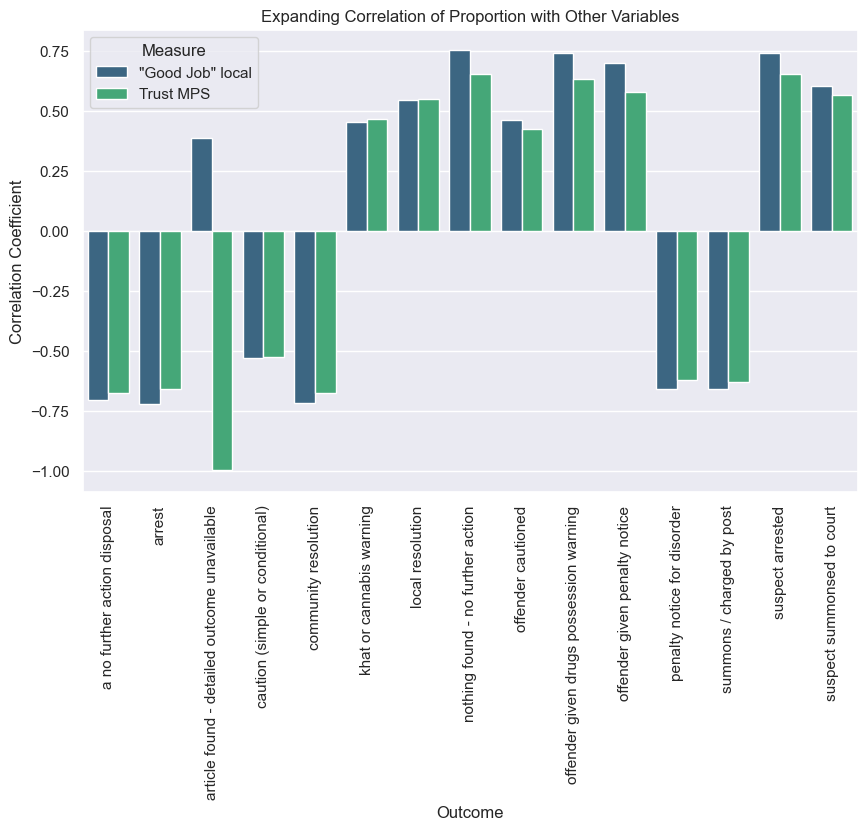

In [5]:
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from scipy.stats import pearsonr
import numpy as np

# Load the data
conn = sqlite3.connect('data/police_data.db')
stop_and_search_df = pd.read_sql_query("SELECT * from stop_and_search", conn)
conn.close()

pas = pd.read_excel('data/PAS.xlsx', sheet_name='Borough')
pas = pas.drop(columns=['Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9'])

# Define Function for preprocessing officer defined ethnicity
def group_ethnicity(row):
    ethnicity = row['officer_defined_ethnicity'].lower()
    if 'white' in ethnicity:
        return 'White'
    elif 'black' in ethnicity:
        return 'Black'
    elif 'asian' in ethnicity or 'chinese' in ethnicity:
        return 'Asian'
    elif 'mixed' in ethnicity or 'other' in ethnicity or 'not stated' in ethnicity:
        return 'Mixed/Other'
    else:
        return 'Unknown'

# Data cleaning steps 
stop_and_search_df = stop_and_search_df[stop_and_search_df['borough'] != 'city of london']
stop_and_search_df.drop(['policing_operation', 'outcome_linked_to_object_of_search', 'removal_of_more_than_just_outer_clothing'], axis=1, inplace=True)
stop_and_search_df.dropna(inplace=True)
stop_and_search_df['month'] = pd.to_datetime(stop_and_search_df['month'])
stop_and_search_df['Year'] = stop_and_search_df['month'].dt.year
stop_and_search_df['Month'] = stop_and_search_df['month'].dt.month
stop_and_search_df = stop_and_search_df.drop('month', axis=1)
pas['Date'] = pd.to_datetime(pas['Date'])
pas['Year'] = pas['Date'].dt.year
pas['Month'] = pas['Date'].dt.month
pas = pas.drop('Date', axis=1)
pas_periods = set(zip(pas['Year'], pas['Month']))
stop_and_search_periods = set(zip(stop_and_search_df['Year'], stop_and_search_df['Month']))
overlap_periods = list(pas_periods.intersection(stop_and_search_periods))
pas = pas[pas.set_index(['Year', 'Month']).index.isin(overlap_periods)]
stop_and_search_df = stop_and_search_df[stop_and_search_df.set_index(['Year', 'Month']).index.isin(overlap_periods)]
pas.rename(columns={'Borough': 'borough'}, inplace=True)
pas['borough'] = pas['borough'].str.lower()
stop_and_search_df['borough'] = stop_and_search_df['borough'].str.lower()
pas['borough'] = pas['borough'].replace('city of westminster', 'westminster')

# Apply the group_ethnicity function
stop_and_search_df['grouped_ethnicity'] = stop_and_search_df.apply(group_ethnicity, axis=1)

# Aggregate the stop_and_search data by borough, Year, Month, and outcome
outcome_agg = stop_and_search_df.groupby(['borough', 'Year', 'Month', 'outcome']).size().unstack(fill_value=0)
outcome_agg = outcome_agg.reset_index()



# Filter for relevant measures in PAS
pas_filtered = pas[pas['Measure'].isin(['"Good Job" local', 'Trust MPS'])]

# Pivot the PAS data to have separate columns for Confidence and Trust
pivot_df = pas_filtered.pivot_table(index=['borough', 'Year', 'Month'], columns='Measure', values='Proportion').reset_index()

# Merge PAS data with the aggregated stop_and_search data
final_df = pd.merge(pivot_df, outcome_agg, on=['borough', 'Year', 'Month'], how='inner')


window_size=4
def calculate_expanding_correlations(final_df, measures, outcomes):
    results = {}
    for measure in measures:
        for outcome in outcomes:
            expanding_corr = final_df.groupby('borough').apply(
                lambda x: x[measure].expanding(window_size).corr(x[outcome])
            ).reset_index(level=0, drop=True)

            # Calculate p-values
            p_values = final_df.groupby('borough').apply(
                lambda x: x[measure].expanding(window_size).apply(
                    lambda y: pearsonr(y, x[outcome].iloc[:len(y)])[1], raw=True
                )
            ).reset_index(level=0, drop=True)

            # Combine correlations and p-values into a DataFrame
            correlation_df = pd.DataFrame({
                'expanding_corr': expanding_corr,
                'p_value': p_values
            })

            # Filter for significant p-values
            significant_correlations = correlation_df[correlation_df['p_value'] <= 0.05]

            # Take the median of significant correlations
            median_significant_corr = significant_correlations['expanding_corr'].median()
            results[(measure, outcome)] = median_significant_corr

    return results

measures = ['"Good Job" local', 'Trust MPS']
outcomes = outcome_agg.columns.drop(['borough', 'Year', 'Month'])
expanding_correlations = calculate_expanding_correlations(final_df, measures, outcomes)

for (measure, outcome), median_corr_value in expanding_correlations.items():
    if not pd.isna(median_corr_value):
        print(f'Measure: {measure}, Outcome: {outcome}\nMedian Significant Correlation: {round(median_corr_value, 4)}')
        print('3===><===3')
        

# Convert the dictionary to a DataFrame
data = []
for key, value in expanding_correlations.items():
    measure, outcome = key
    corr_value = value
    if not np.isnan(corr_value):
        data.append([measure, outcome, corr_value])

df = pd.DataFrame(data, columns=['Measure', 'Outcome', 'correlation_value'])

# Plotting
plt.figure(figsize=(10, 6))
sns.set(style="darkgrid")

# Create a bar plot
bar_plot = sns.barplot(
    x='Outcome',
    y='correlation_value',
    hue='Measure',
    data=df,
    palette='viridis'
)

# Rotate x labels for better readability
bar_plot.set_xticklabels(bar_plot.get_xticklabels(), rotation=90)

# Add title and labels
plt.title('Expanding Correlation of Proportion with Other Variables')
plt.xlabel('Outcome')
plt.ylabel('Correlation Coefficient')

# Show plot
plt.show()